** FIND 'SIMPLE MODEL' HEADER 3/4 OF THE WAY DOWN **

# Airbnb - Reviews & Price NLP

## Overview

I have been contacted by a boutique real estate firm out of Manhattan Beach California to help them optimize the Airbnb branch of their business. With hundreds of properties across Los Angeles, this firm wants to ensure that they are maximizing return on each of their properties by setting an optimal per night price point. With numerous written reviews for each of their properties, they wish uncover whether these written reviews can be used to set optimal price points.

## Business Understanding

To perform this analysis, I have chosen to use Natural Language Processing (NLP) to build a classification model to explore whether Airbnb written reviews are reliable predictors for the ‘price per night’ of a given Airbnb listing. Specifically, for one bedroom listings as they occupy the majority of Airbnb listings in the greater Los Angeles. Based on the results, this analysis will aim to communicate clear recommendations on how to utilize this model to optimize Airbnb price listing strategy.

Let's dive in...

### Imports
We'll start with importing the relevant packages:

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict


[nltk_data] Downloading package stopwords to /Users/jf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#load in rviews and listings data
la_rev = pd.read_csv('../data/la_reviews.csv')
la_list = pd.read_csv('../data/la_listings.csv')

## 'Reviews' DF cleaning

In [3]:
la_rev

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,8941071,68391055,2016-04-04,10164333,Smruti,"Danielle was a great host, she was extremely r..."
1,8941071,153719836,2017-05-21,97944097,Rob,The apartment was great for us to spend the we...
2,8941071,147589354,2017-04-27,4123723,Widya,"Danielle is a great host, very concerned with..."
3,8941071,145742425,2017-04-19,1459499,Darian,Great location and spacious. Danielle's place ...
4,8941071,144400833,2017-04-15,98494277,Charlie,"Danielle's place was as expected, really good ..."
...,...,...,...,...,...,...
1532920,837764720715019063,882048452895718293,2023-05-01,61709926,Xana,Alexis and David were incredible hosts - frien...
1532921,837764720715019063,866817204898142401,2023-04-10,20783675,Priscila,Such an amazing and beautiful place! David and...
1532922,837764720715019063,864618654800651449,2023-04-07,407565907,Petra,The owners were very kind and helpful. Beautif...
1532923,837764720715019063,850814630932374093,2023-03-19,129150527,Mike,"Beautiful space and view, very friendly hosts,..."


In [4]:
la_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532925 entries, 0 to 1532924
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1532925 non-null  int64 
 1   id             1532925 non-null  int64 
 2   date           1532925 non-null  object
 3   reviewer_id    1532925 non-null  int64 
 4   reviewer_name  1532925 non-null  object
 5   comments       1532639 non-null  object
dtypes: int64(3), object(3)
memory usage: 70.2+ MB


In [5]:
#checking for nulls
la_rev['comments'].isna().sum()

286

In [6]:
#visualizing nulls
la_rev[la_rev['comments'].isna()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11041,12232198,597570153,2020-01-25,109869097,Larry,NaN
36262,18771571,499592244,2019-07-31,200662007,Lilyan,NaN
38689,19966810,428734333,2019-03-25,248109683,Danielle,NaN
39068,20012997,500736816306141481,2021-11-21,78355861,Jill,NaN
40846,19434972,486204261023070433,2021-11-01,110160469,Farnaz,NaN
...,...,...,...,...,...,...
1511887,16661893,621560353,2020-04-01,342670536,Al,NaN
1514989,46444583,868264023745043602,2023-04-12,23149537,Flannery,NaN
1517560,19332411,222064868,2017-12-28,113707624,Betsy,NaN
1524215,30460122,561530122,2019-11-09,207881679,Bianca,NaN


In [7]:
#dropping null values
la_rev.dropna(subset=['comments'], inplace=True)

In [8]:
la_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532639 entries, 0 to 1532924
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1532639 non-null  int64 
 1   id             1532639 non-null  int64 
 2   date           1532639 non-null  object
 3   reviewer_id    1532639 non-null  int64 
 4   reviewer_name  1532639 non-null  object
 5   comments       1532639 non-null  object
dtypes: int64(3), object(3)
memory usage: 81.9+ MB


In [9]:
#checking separate rewviews for s specific listing_id BEFORE grouping all review by listing_id
la_rev[la_rev['listing_id'] == 109]

,listing_id,id,date,reviewer_id,reviewer_name,comments
497553,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
497554,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...


In [10]:
#grouping all reviews text by 'listing_id'
la_rev_con = la_rev.groupby(['listing_id'], as_index=False).agg({'comments': " ".join})

In [11]:
la_rev_con

,listing_id,comments
0,109,Me and two friends stayed for four and a half ...
1,2708,Charles is the man!! Just wrapped up an amazin...
2,2732,"Unfortunately, I was really disappointed with ..."
3,6033,Sarah was a great host. She was always quick t...
4,6931,The best host and best stay I've ever had with...
...,...,...
32956,968513441909611726,BEAUTIFUL HOME. GREAT LOCATION. AWESOME SUPER ...
32957,969535403681694277,We had a perfect time at Sean’s cottage. It wa...
32958,969626715256159808,Kelly was communicative and super responsive. ...
32959,970252209631292696,Such a cute spot in a nice neighborhood… check...


In [12]:
#sanity check: (cross-referencing with listing_id 109 above
la_rev_con['comments'][0]

"Me and two friends stayed for four and a half months. It was a great place to stay! The apartment was very comfortable and I really enjoyed having the park with running path across the street. The only downside was it wasn't within walking distance to restaurants, bars, or coffee shops. But they are a short drive away. Overall, great stay! The host canceled my reservation the day before arrival."

## 'Listings' DF cleaning

In [13]:
la_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44594 entries, 0 to 44593
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            44594 non-null  int64  
 1   listing_url                                   44594 non-null  object 
 2   scrape_id                                     44594 non-null  int64  
 3   last_scraped                                  44594 non-null  object 
 4   source                                        44594 non-null  object 
 5   name                                          44594 non-null  object 
 6   description                                   43937 non-null  object 
 7   neighborhood_overview                         25053 non-null  object 
 8   picture_url                                   44594 non-null  object 
 9   host_id                                       44594 non-null 

In [14]:
la_list[la_list['id'] == 8941071]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
4276,8941071,https://www.airbnb.com/rooms/8941071,20230903194229,2023-09-03,previous scrape,Rental unit in West Hollywood · ★4.81 · 1 bedr...,"Perfect heart of the city feeling, short walk ...",NaN,https://a0.muscache.com/pictures/ba9498f2-815d...,23592617,...,5.0,4.95,4.84,NaN,f,1,1,0,0,0.24


In [15]:
la_list['review_scores_rating'].value_counts()

5.00    10388
4.50      838
4.00      778
4.67      755
4.88      728
        ...  
3.56        1
2.75        1
3.14        1
3.96        1
4.03        1
Name: review_scores_rating, Length: 157, dtype: int64

In [16]:
#condensing df to potential features of interest for NLP
la_small = la_list[['id', 'price', 'bedrooms', 'review_scores_rating', 'neighbourhood_cleansed', 
                    'minimum_nights', 'maximum_nights']]

In [17]:
la_small['bedrooms'].value_counts()

1.0     13872
2.0      8313
3.0      5008
4.0      2494
5.0      1008
6.0       334
7.0       124
8.0        40
9.0        20
10.0       12
11.0        6
14.0        4
12.0        4
13.0        3
18.0        2
20.0        1
23.0        1
16.0        1
32.0        1
24.0        1
19.0        1
15.0        1
Name: bedrooms, dtype: int64

In [18]:
# Filtering for 1 bedroom properties - Analysis only concerned with 1 bedroom Airbnb listings
df_la_1bd = la_small[la_small['bedrooms'] == 1.0]

In [19]:
# removing decimals from price points
df_la_1bd['price'] = df_la_1bd['price'].str.split('.').str[0]

<ipython-input-19-57e69bcbee19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_la_1bd['price'] = df_la_1bd['price'].str.split('.').str[0]


In [20]:
#removing commas from price points
df_la_1bd['price'] = df_la_1bd['price'].str.replace(",", "")
df_la_1bd['price']

<ipython-input-20-66a038499213>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_la_1bd['price'] = df_la_1bd['price'].str.replace(",", "")


2         $69
3        $120
8        $201
11        $88
15        $60
         ... 
44586    $175
44587    $194
44588    $180
44590    $168
44593    $480
Name: price, Length: 13872, dtype: object

In [21]:
#removing $ signs from price points
df_la_1bd['price'] = df_la_1bd['price'].str.replace('$', '')
df_la_1bd

<ipython-input-21-58d73e53b54c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_la_1bd['price'] = df_la_1bd['price'].str.replace('$', '')


,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights
2,942342470598573002,69,1.0,NaN,Rowland Heights,1,365
3,41240375,120,1.0,5.00,Playa del Rey,30,1125
8,15239926,201,1.0,4.99,Santa Clarita,2,30
11,14821183,88,1.0,3.00,Diamond Bar,1,1125
15,18976122,60,1.0,NaN,Fairfax,30,1125
...,...,...,...,...,...,...,...
44586,720164781296601135,175,1.0,4.75,West Hollywood,2,1125
44587,960073745720655216,194,1.0,NaN,Downtown,30,365
44588,680301812424175952,180,1.0,4.50,Downtown,30,365
44590,674665451875208878,168,1.0,NaN,Downtown,30,365


## Merge 'Reviews' and 'Listings'

In [22]:
# merge 'reviews' df with filtered 'listings' df
df_merge = df_la_1bd.merge(la_rev_con, how='left', left_on='id', right_on='listing_id')

In [23]:
df_merge

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments
0,942342470598573002,69,1.0,NaN,Rowland Heights,1,365,NaN,NaN
1,41240375,120,1.0,5.00,Playa del Rey,30,1125,4.124038e+07,Paola is the best host I have ever had. She ha...
2,15239926,201,1.0,4.99,Santa Clarita,2,30,1.523993e+07,Fantastic super hosts and space . What a beaut...
3,14821183,88,1.0,3.00,Diamond Bar,1,1125,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...
4,18976122,60,1.0,NaN,Fairfax,30,1125,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13867,720164781296601135,175,1.0,4.75,West Hollywood,2,1125,7.201648e+17,"Great location, great host, beautiful apartmen..."
13868,960073745720655216,194,1.0,NaN,Downtown,30,365,NaN,NaN
13869,680301812424175952,180,1.0,4.50,Downtown,30,365,6.803018e+17,Very convenient and comfortable. It had everyt...
13870,674665451875208878,168,1.0,NaN,Downtown,30,365,NaN,NaN


In [31]:
#convert 'price' column to int
df_merge['price'] = df_merge['price'].astype(int)

Drop any long term or monthly listings - listings that have a 30-day minimum stay.

In [38]:
#drop long term stays
longterm_stays = df_merge[df_merge['minimum_nights'] >= 30].index
df_merge.drop(longterm_stays, inplace=True)

In [39]:
#sanity check
df_merge[df_merge['minimum_nights'] >= 30]

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments


Exploring 'price' feature for any outliers.

In [40]:
df_merge[df_merge['price'] > 1000]

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments
223,35843831,9999,1.0,5.00,Studio City,1,1125,3.584383e+07,Great time here. Thanks guys
228,35843690,9999,1.0,1.00,Studio City,1,1125,3.584369e+07,Overpriced and overrated. If you’re bringing y...
924,37557082,1500,1.0,5.00,Malibu,7,1125,3.755708e+07,"What a great place! Peaceful, beautiful and ho..."
1132,52619433,3130,1.0,4.33,Glendale,2,365,5.261943e+07,Dymund was great!! Place was nice and clean ev...
1186,812386491863587915,9999,1.0,5.00,Pasadena,1,1125,8.123865e+17,Great stay! Really spacious for my partner and...
1890,812389869434454826,9999,1.0,5.00,Pasadena,1,1125,8.123899e+17,"The room is in a hotel, and the photos on AirB..."
2010,35633263,9999,1.0,5.00,Studio City,1,1125,3.563326e+07,Wonderful place!
2905,38755677,5000,1.0,4.95,Universal City,1,28,3.875568e+07,Alex along with his place were very nice! Alex...
3141,18979304,99999,1.0,4.98,Beverly Hills,1,1125,1.897930e+07,We appreciated the accommodations during our r...
4107,19769097,9999,1.0,4.95,Beverly Hills,1,1125,1.976910e+07,Great location and Sugar (the worlds sweetest ...


In [41]:
df_merge[df_merge['price'] > 700]

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments
223,35843831,9999,1.0,5.00,Studio City,1,1125,3.584383e+07,Great time here. Thanks guys
228,35843690,9999,1.0,1.00,Studio City,1,1125,3.584369e+07,Overpriced and overrated. If you’re bringing y...
834,1157077,895,1.0,5.00,Malibu,4,60,1.157077e+06,. This is one amazing gem of a place to stay i...
924,37557082,1500,1.0,5.00,Malibu,7,1125,3.755708e+07,"What a great place! Peaceful, beautiful and ho..."
1132,52619433,3130,1.0,4.33,Glendale,2,365,5.261943e+07,Dymund was great!! Place was nice and clean ev...
1186,812386491863587915,9999,1.0,5.00,Pasadena,1,1125,8.123865e+17,Great stay! Really spacious for my partner and...
1533,43752822,770,1.0,4.96,Malibu,1,1125,4.375282e+07,"Lovely stay, thank you very much. Nice place t..."
1890,812389869434454826,9999,1.0,5.00,Pasadena,1,1125,8.123899e+17,"The room is in a hotel, and the photos on AirB..."
2010,35633263,9999,1.0,5.00,Studio City,1,1125,3.563326e+07,Wonderful place!
2905,38755677,5000,1.0,4.95,Universal City,1,28,3.875568e+07,Alex along with his place were very nice! Alex...


In [27]:
#check for numerical values in text data
df_merge[df_merge['comments'].str.isnumeric() == True]

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,minimum_nights,maximum_nights,listing_id,comments


In [28]:
#checking for nulls in reviews
df_merge['comments'].isna().sum()

4003

In [29]:
#dropping nulls from reviews
df_merge.dropna(subset=['comments'], inplace=True)

In [30]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9869 entries, 1 to 13869
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9869 non-null   int64  
 1   price                   9869 non-null   object 
 2   bedrooms                9869 non-null   float64
 3   review_scores_rating    9869 non-null   float64
 4   neighbourhood_cleansed  9869 non-null   object 
 5   minimum_nights          9869 non-null   int64  
 6   maximum_nights          9869 non-null   int64  
 7   listing_id              9869 non-null   float64
 8   comments                9869 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 771.0+ KB


## Pre-Processing Text

In [152]:
#instantiate tokenizer
#regex pattern returns words or 3 or more characters and drops all non-english characters
token_pattern = r"(?u)\w{3,}|/[^\x00-\x7F]+/"
tokenizer = RegexpTokenizer(token_pattern)

#create a list of stopwords
stopwords_list = stopwords.words('english')

In [153]:
#create function to pre-process text
def preprocess_text(text, tokenizer, stopwords_list):
    # Standardize case (lowercase the text)
    text_std = text.lower()
    # Tokenize
    token_list = tokenizer.tokenize(text_std)
    # Remove stopwords
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed
   

In [154]:
#pre-process the text data with 'preprocess_text' function
reviews_proc = df_merge.comments.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list))
reviews_proc

1        [paola, best, host, ever, taken, care, every, ...
2        [fantastic, super, hosts, space, beautiful, pl...
3        [quiet, house, bedroom, enough, sleeping, uncl...
6        [amazing, experience, house, also, recently, u...
7        [nice, neighborhood, hosts, great, location, h...
                               ...                        
13862    [super, host, thank, apartment, perfect, work,...
13863    [great, location, overall, decent, stay, bigge...
13864    [since, sent, review, guess, reviewing, confir...
13867    [great, location, great, host, beautiful, apar...
13869    [convenient, comfortable, everything, could, n...
Name: comments, Length: 9869, dtype: object

In [168]:
reviews_proc[1]

['paola',
 'best',
 'host',
 'ever',
 'taken',
 'care',
 'every',
 'detail',
 'always',
 'looking',
 'comfort',
 'thee',
 'condo',
 'great',
 'garage',
 'parking',
 'laundry',
 'room',
 'site',
 'works',
 'perfectly',
 'cheap',
 'easy',
 'use',
 'app',
 'appliances',
 'new',
 'kitchenware',
 'complete',
 'ever',
 'seen',
 'arbnb',
 'condo',
 'pretty',
 'good',
 'size',
 'comes',
 'working',
 'corner',
 'screen',
 'multifunction',
 'printer',
 'balcony',
 'really',
 'cute',
 'good',
 'size',
 'perfect',
 'place',
 'read',
 'simply',
 'rest',
 'armchairs',
 'furniture',
 'good',
 'quality',
 'everything',
 'makes',
 'place',
 'cozy',
 'neighborhood',
 'fantastic',
 'safe',
 'truly',
 'minutes',
 'walk',
 'beach',
 'minutes',
 'walk',
 'nearest',
 'food',
 'store',
 'howe',
 'handy',
 'best',
 'paola',
 'landlady',
 'always',
 'take',
 'care',
 'make',
 'stay',
 'comfortable',
 'unforgettable',
 'highly',
 'recommend',
 'condo',
 'paola']

### Tag & Lemmatize

In [161]:
#Create Lemmatizer
lemmatizer = WordNetLemmatizer()

In [162]:
#Map POS tag to first character for use in WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN

In [163]:
#POS Tagging
tagged_text = reviews_proc.apply(lambda x: pos_tag(x))

In [164]:
tagged_text

1        [(paola, NN), (best, JJS), (host, NN), (ever, ...
2        [(fantastic, JJ), (super, JJ), (hosts, NNS), (...
3        [(quiet, JJ), (house, NN), (bedroom, NN), (eno...
6        [(amazing, VBG), (experience, NN), (house, NN)...
7        [(nice, JJ), (neighborhood, NN), (hosts, NNS),...
                               ...                        
13862    [(super, NN), (host, NN), (thank, NN), (apartm...
13863    [(great, JJ), (location, NN), (overall, JJ), (...
13864    [(since, IN), (sent, VBN), (review, NN), (gues...
13867    [(great, JJ), (location, NN), (great, JJ), (ho...
13869    [(convenient, NN), (comfortable, JJ), (everyth...
Name: comments, Length: 9869, dtype: object

In [171]:
#Lemmatize the processed text
processed_rev = tagged_text.apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in x])

In [172]:
#create new column in df with the processed reviews
df_merge['processed_reviews'] = processed_rev
df_merge

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
1,41240375,120,1.0,5.00,Playa del Rey,4.124038e+07,Paola is the best host I have ever had. She ha...,"[paola, best, host, ever, take, care, every, d..."
2,15239926,201,1.0,4.99,Santa Clarita,1.523993e+07,Fantastic super hosts and space . What a beaut...,"[fantastic, super, host, space, beautiful, pla..."
3,14821183,88,1.0,3.00,Diamond Bar,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,"[quiet, house, bedroom, enough, sleep, unclean]"
6,26296415,180,1.0,5.00,Torrance,2.629642e+07,Amazing experience. The house was also recentl...,"[amaze, experience, house, also, recently, upg..."
7,22746714,35,1.0,4.57,North El Monte,2.274671e+07,Nice neighborhood and hosts. Great location. T...,"[nice, neighborhood, host, great, location, ho..."
...,...,...,...,...,...,...,...,...
13862,575384126844892676,159,1.0,4.67,West Hollywood,5.753841e+17,"Super host, thank you! This apartment was perf...","[super, host, thank, apartment, perfect, work,..."
13863,16072625,177,1.0,4.14,East Hollywood,1.607262e+07,Great location. And overall a decent stay. My ...,"[great, location, overall, decent, stay, big, ..."
13864,924091269757225413,120,1.0,1.00,Beverly Hills,9.240913e+17,"Since they sent me a review, I guess I’m revie...","[since, send, review, guess, review, confirm, ..."
13867,720164781296601135,175,1.0,4.75,West Hollywood,7.201648e+17,"Great location, great host, beautiful apartmen...","[great, location, great, host, beautiful, apar..."


In [173]:
#convert token lists to strings
df_merge['processed_reviews'] = df_merge['processed_reviews'].str.join(' ')

In [174]:
df_merge

,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
1,41240375,120,1.0,5.00,Playa del Rey,4.124038e+07,Paola is the best host I have ever had. She ha...,paola best host ever take care every detail al...
2,15239926,201,1.0,4.99,Santa Clarita,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...
3,14821183,88,1.0,3.00,Diamond Bar,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean
6,26296415,180,1.0,5.00,Torrance,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...
7,22746714,35,1.0,4.57,North El Monte,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...
...,...,...,...,...,...,...,...,...
13862,575384126844892676,159,1.0,4.67,West Hollywood,5.753841e+17,"Super host, thank you! This apartment was perf...",super host thank apartment perfect work stay s...
13863,16072625,177,1.0,4.14,East Hollywood,1.607262e+07,Great location. And overall a decent stay. My ...,great location overall decent stay big issue p...
13864,924091269757225413,120,1.0,1.00,Beverly Hills,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...
13867,720164781296601135,175,1.0,4.75,West Hollywood,7.201648e+17,"Great location, great host, beautiful apartmen...",great location great host beautiful apartment ...


In [ ]:
df_merge_processed = df_merge

In [ ]:
#create csv of processed reviews df with initial regex pattern
df_merge_processed.to_csv('../data/processed_reviews.csv')

In [175]:
df_merge_processed2 = df_merge

In [176]:
#create csv of processed reviews df with NEW regex pattern
df_merge_processed2.to_csv('../data/processed_reviews2.csv')

## Modeling

In [76]:
df_processed = pd.read_csv('../data/processed_reviews.csv')
df_processed

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
0,1,41240375,120.0,1.0,5.00,Playa del Rey,4.124038e+07,Paola is the best host I have ever had. She ha...,paola best host ever take care every detail al...
1,2,15239926,201.0,1.0,4.99,Santa Clarita,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...
2,3,14821183,88.0,1.0,3.00,Diamond Bar,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean
3,6,26296415,180.0,1.0,5.00,Torrance,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...
4,7,22746714,35.0,1.0,4.57,North El Monte,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...
...,...,...,...,...,...,...,...,...,...
9866,13862,575384126844892676,159.0,1.0,4.67,West Hollywood,5.753841e+17,"Super host, thank you! This apartment was perf...",super host thank apartment perfect work stay s...
9867,13863,16072625,177.0,1.0,4.14,East Hollywood,1.607262e+07,Great location. And overall a decent stay. My ...,great location overall decent stay big issue p...
9868,13864,924091269757225413,120.0,1.0,1.00,Beverly Hills,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...
9869,13867,720164781296601135,175.0,1.0,4.75,West Hollywood,7.201648e+17,"Great location, great host, beautiful apartmen...",great location great host beautiful apartment ...


In [78]:
#checking for nulls
df_processed.isna().sum()

Unnamed: 0                 0
id                         0
price                      2
bedrooms                   2
review_scores_rating       2
neighbourhood_cleansed     2
listing_id                 2
comments                   2
processed_reviews         11
dtype: int64

In [79]:
#dropping nulls
df_processed.dropna(inplace=True)
df_processed.isna().sum()

Unnamed: 0                0
id                        0
price                     0
bedrooms                  0
review_scores_rating      0
neighbourhood_cleansed    0
listing_id                0
comments                  0
processed_reviews         0
dtype: int64

In [80]:
#convert 'price' column to int
df_processed['price'] = df_processed['price'].astype(int)

In [81]:
#train test split 
X = df_processed["processed_reviews"]
y = df_processed["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#sanity check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7395,), (2465,), (7395,), (2465,))

### Linear Regression

In [64]:
#instantiate simple model 
pipe_lr = Pipeline([("vec", CountVectorizer()), ("lreg", LinearRegression())])

In [67]:
from sklearn.model_selection import cross_validate

In [68]:
scores = cross_validate(pipe_lr, X_train, y_train, cv=3, 
                        scoring=('r2', 'neg_mean_squared_error'), 
                        return_train_score=True)

In [71]:
scores

{'fit_time': array([878.05117702, 591.76208997, 739.64259696]),
 'score_time': array([2.25494194, 1.80523682, 2.06091213]),
 'test_r2': array([ -178.56458962, -2651.70339649, -5278.74265526]),
 'train_r2': array([0.99903127, 0.99930777, 0.99951327]),
 'test_neg_mean_squared_error': array([-7.30324878e+08, -9.05486962e+09, -7.63545058e+08]),
 'train_neg_mean_squared_error': array([-1723.67717788, -1457.95388423, -1820.54631292])}

### Converting Tagret Variable ('Price') to Discrete

In [ ]:
#create a column that sorts price based on categories of ranges of price
conditions = [
    (df_processed['price'] <= 100),
    (df_processed['price'] > 100) & (df_processed['price'] <= 150),
    (df_processed['price'] > 150) & (df_processed['price'] <= 200),
    (df_processed['price'] > 200) & (df_processed['price'] <= 250),
    (df_processed['price'] > 250) & (df_processed['price'] <= 300),
    (df_processed['price'] > 300)]

#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4, 5, 6]

#create a new column and use np.select to assign values to it using our lists as arguments
df_processed['price_range'] = np.select(conditions, values)
df_processed

### Additional Models & GridSearch

In [74]:
#Instantiate various pipelines
pipe_gbr = Pipeline([("vec", TfidfVectorizer()), ("gbr", GradientBoostingRegressor(random_state=42))])
pipe_ridge = Pipeline([("vec", TfidfVectorizer()), ("rdg", Ridge(random_state=42))])
pipe_dt = Pipeline([("vec", TfidfVectorizer()), ("dt", DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([("vec", TfidfVectorizer()), ("rf", RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([("vec", TfidfVectorizer()), ("knn", KNeighborsClassifier())])


In [75]:
grid_dt = {'dt__max_depth': ['None', 2, 5, 10],
       'dt__min_samples_split': [2, 5],
       'vec__ngram_range': [(1,1), (1,2)],
        'vec__max_df': [.8, .9, .99],
        'vec__min_df': [.01, .05]}
gs = GridSearchCV(estimator=pipe_dt, param_grid=grid_dt, verbose=2)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.8s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.5s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  14.2s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8

[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.0s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8

[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   8.1s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.5s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  22.0s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.4s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.2s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.9s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.9s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  22.0s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   8.3s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   8.4s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   8.3s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   8.2s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.5s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.5s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.5s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.5s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.2s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.2s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.7s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  10.5s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.6s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.9s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.6s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  24.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec_

[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  35.3s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  34.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  35.1s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  34.4s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  19.6s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  20.5s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  20.2s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.

[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  32.7s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  18.2s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  17.9s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=  17.8s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  44.5s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in 

GridSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__max_depth': ['None', 2, 5, 10],
                         'dt__min_samples_split': [2, 5],
                         'vec__max_df': [0.8, 0.9, 0.99],
                         'vec__min_df': [0.01, 0.05],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

## SIMPLE MODEL

**train test split with 'price' as a discrete target**

In [107]:
#train test split
X = df_processed["processed_reviews"]
y = df_processed["price_range"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7395,), (2465,), (7395,), (2465,))

### Baseline Model - ***Old Regex Pattern***

In [26]:
#instantiate pipeline for basic Logistic Regression
pipe_logr_bas = Pipeline([("vec", CountVectorizer()), ("lreg", LogisticRegression(max_iter=10000))])

In [95]:
#cross-validate & return scores
scores = cross_validate(pipe_logr_range, X_train, y_train, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([163.30727196, 173.14294314, 158.89530182]),
 'score_time': array([1.86575103, 2.10764313, 2.17601728]),
 'test_score': array([0.40040568, 0.40081136, 0.39553753]),
 'train_score': array([0.97667343, 0.97931034, 0.97565923])}

### Logistic Regression - GridSearch

In [100]:
pipe_logr = Pipeline([("vec", TfidfVectorizer()), ("lreg", LogisticRegression())])

In [102]:
#Grid search for hyperparameter tuning the Logistic Regression

#Define parameter grid for the vectorizer and logistic regression
log_param_grid = {
    'vec__min_df': [.01, .02, .03],
    'vec__max_df': [.88, .90, .92],
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'lreg__penalty': [None, 'l2', 'l1'],
    'lreg__class_weight': [None, 'balanced'],
    'lreg__solver': ['lbfgs', 'liblinear'],
    'lreg__max_iter': [1000, 10000]
}


log_grid = GridSearchCV(pipe_logr, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('lreg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'lreg__class_weight': [None, 'balanced'],
                         'lreg__max_iter': [1000, 10000],
                         'lreg__penalty': [None, 'l2', 'l1'],
                         'lreg__solver': ['lbfgs', 'liblinear'],
                         'vec__max_df': [0.88, 0.9, 0.92],
                         'vec__min_df': [0.01, 0.02, 0.03],
                         'vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [106]:
log_grid.best_params_

{'lreg__class_weight': None,
 'lreg__max_iter': 1000,
 'lreg__penalty': 'l2',
 'lreg__solver': 'lbfgs',
 'vec__max_df': 0.9,
 'vec__min_df': 0.03,
 'vec__ngram_range': (1, 3)}

In [105]:
log_grid.best_score_

0.45990534144692363

**5% improvement in tuned logistic regression model with Tf-Idf vectorizer**

### Decision Tree Classifier - ***Old Regex Pattern***

In [113]:
pipe_dt = Pipeline([("vec", TfidfVectorizer()), ("dt", DecisionTreeClassifier(random_state=42))])

In [114]:
#set up parameter grid
grid_dt = {'dt__max_depth': ['None', 2, 5, 10],
       'dt__min_samples_split': [2, 5],
       'vec__ngram_range': [(1,1), (1,2)],
        'vec__max_df': [.8, .9, .99],
        'vec__min_df': [.01, .05]}
#instantiate Grid Search for decision tree and vectorizer
gs = GridSearchCV(estimator=pipe_dt, param_grid=grid_dt, verbose=2)

#fit it to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.5s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.5s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.7s
[CV] END dt__max_depth=None, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  14.1s
[CV] EN

[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.4s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END dt__max_depth=None, dt__min_samples_split=5, vec__max_df=0.8

[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END dt__max_depth=2, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.7s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  16.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   5.8s
[CV] END dt__max_depth=2, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.01, vec__ngram_range=(1, 2); total time=  19.3s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=5, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.9s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END dt__max_depth=5, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec_

[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.1s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.9s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.4s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.2s
[CV] END dt__max_depth=10, dt__min_samples_split=2, vec__max_df=0.9, vec__min_df=0.

[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  21.6s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.8, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.4s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.0s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   8.9s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1); total time=   9.1s
[CV] END dt__max_depth=10, dt__min_samples_split=5, vec__max_df=0.9, vec__min_df=0.

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in 

GridSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__max_depth': ['None', 2, 5, 10],
                         'dt__min_samples_split': [2, 5],
                         'vec__max_df': [0.8, 0.9, 0.99],
                         'vec__min_df': [0.01, 0.05],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [120]:
y_train.value_counts()

2    2576
1    2166
3    1407
4     610
6     341
5     295
Name: price_range, dtype: int64

In [121]:
X_train.value_counts()

host cancel reservation day arrival automate post                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Modeling - New Regex Pattern

In [50]:
df_processed2 = pd.read_csv('../data/processed_reviews2.csv')
df_processed2

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
0,1,41240375,120.0,1.0,5.00,Playa del Rey,4.124038e+07,Paola is the best host I have ever had. She ha...,paola best host ever take care every detail al...
1,2,15239926,201.0,1.0,4.99,Santa Clarita,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...
2,3,14821183,88.0,1.0,3.00,Diamond Bar,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean
3,6,26296415,180.0,1.0,5.00,Torrance,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...
4,7,22746714,35.0,1.0,4.57,North El Monte,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...
...,...,...,...,...,...,...,...,...,...
9866,13862,575384126844892676,159.0,1.0,4.67,West Hollywood,5.753841e+17,"Super host, thank you! This apartment was perf...",super host thank apartment perfect work stay s...
9867,13863,16072625,177.0,1.0,4.14,East Hollywood,1.607262e+07,Great location. And overall a decent stay. My ...,great location overall decent stay big issue p...
9868,13864,924091269757225413,120.0,1.0,1.00,Beverly Hills,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...
9869,13867,720164781296601135,175.0,1.0,4.75,West Hollywood,7.201648e+17,"Great location, great host, beautiful apartmen...",great location great host beautiful apartment ...


Exploring 'price' breakdown by looking at the inter quartile range (IQR).

In [52]:
df_processed2['price'].describe()

count     9869.000000
mean       182.569359
std       1398.983133
min         10.000000
25%         99.000000
50%        130.000000
75%        177.000000
max      99999.000000
Name: price, dtype: float64

In [57]:
df_processed2.loc[df_processed2['price'] > 600]

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
23,53,42331295,672.0,1.0,4.76,Malibu,4.233130e+07,It is a wonderful apartment by the beach. whet...,wonderful apartment beach whether want tranqui...
140,223,35843831,9999.0,1.0,5.00,Studio City,3.584383e+07,Great time here. Thanks guys,great time thanks guy
144,228,35843690,9999.0,1.0,1.00,Studio City,3.584369e+07,Overpriced and overrated. If you’re bringing y...,overprice overrate bring family especially sma...
165,262,3284198,739.0,1.0,4.83,Venice,3.284198e+06,"Great location, easy and walkable access to th...",great location easy walkable access main road ...
241,391,39104651,1000.0,1.0,4.00,Malibu,3.910465e+07,"Clean, comfortable and modern room, 15 minute ...",clean comfortable modern room minute walk mali...
453,814,39104671,1000.0,1.0,5.00,Malibu,3.910467e+07,Perfect location. Great location and nice and ...,perfect location great location nice clean
464,834,1157077,895.0,1.0,5.00,Malibu,1.157077e+06,. This is one amazing gem of a place to stay i...,one amaze gem place stay malibu honestly feel ...
535,924,37557082,1500.0,1.0,5.00,Malibu,3.755708e+07,"What a great place! Peaceful, beautiful and ho...",great place peaceful beautiful host friendly f...
619,1043,3563679,643.0,1.0,4.99,Malibu,3.563679e+06,Connie’s place was absolutely magic. 🤍🌊🐚 Looks...,connie place absolutely magic look like photo ...
683,1132,52619433,3130.0,1.0,4.33,Glendale,5.261943e+07,Dymund was great!! Place was nice and clean ev...,dymund great place nice clean everything stand...


In [58]:
df_processed2.loc[df_processed2['price'] > 2000]

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews
140,223,35843831,9999.0,1.0,5.00,Studio City,3.584383e+07,Great time here. Thanks guys,great time thanks guy
144,228,35843690,9999.0,1.0,1.00,Studio City,3.584369e+07,Overpriced and overrated. If you’re bringing y...,overprice overrate bring family especially sma...
683,1132,52619433,3130.0,1.0,4.33,Glendale,5.261943e+07,Dymund was great!! Place was nice and clean ev...,dymund great place nice clean everything stand...
719,1186,812386491863587915,9999.0,1.0,5.00,Pasadena,8.123865e+17,Great stay! Really spacious for my partner and...,great stay really spacious partner clean cozy ...
1196,1890,812389869434454826,9999.0,1.0,5.00,Pasadena,8.123899e+17,"The room is in a hotel, and the photos on AirB...",room hotel photo airbnb depict upgraded room a...
1286,2010,35633263,9999.0,1.0,5.00,Studio City,3.563326e+07,Wonderful place!,wonderful place
1788,2778,7023661,9998.0,1.0,5.00,Alhambra,7.023661e+06,Ficar hospedada no apartamento da Vivian e do ...,ficar hospedada apartamento vivian cuyler fez ...
1856,2905,38755677,5000.0,1.0,4.95,Universal City,3.875568e+07,Alex along with his place were very nice! Alex...,alex along place nice alex respond quickly eve...
1987,3141,18979304,99999.0,1.0,4.98,Beverly Hills,1.897930e+07,We appreciated the accommodations during our r...,appreciated accommodation recent stay guest ho...
2700,4107,19769097,9999.0,1.0,4.95,Beverly Hills,1.976910e+07,Great location and Sugar (the worlds sweetest ...,great location sugar world sweetest dog welcom...


### Converting Tagret Variable ('Price') to Discrete

Using each inter quartile as a range of prices to convert the 'price' target variable to a discrete variable.

In [16]:
#create a column that sorts price based on categories of ranges of price
conditions = [
    (df_processed2['price'] <= 99),
    (df_processed2['price'] > 99) & (df_processed2['price'] <= 130),
    (df_processed2['price'] > 130) & (df_processed2['price'] <= 177),
    (df_processed2['price'] > 200) & (df_processed2['price'] <= 250),
    (df_processed2['price'] > 250) & (df_processed2['price'] <= 300),
    (df_processed2['price'] > 300)]

#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4, 5, 6]

#create a new column and use np.select to assign values to it using our lists as arguments
df_processed2['price_range'] = np.select(conditions, values)
df_processed2

,Unnamed: 0,id,price,bedrooms,review_scores_rating,neighbourhood_cleansed,listing_id,comments,processed_reviews,price_range
0,1,41240375,120.0,1.0,5.00,Playa del Rey,4.124038e+07,Paola is the best host I have ever had. She ha...,paola best host ever take care every detail al...,2
1,2,15239926,201.0,1.0,4.99,Santa Clarita,1.523993e+07,Fantastic super hosts and space . What a beaut...,fantastic super host space beautiful place sta...,4
2,3,14821183,88.0,1.0,3.00,Diamond Bar,1.482118e+07,Quiet house. Bedroom is enough for sleeping. u...,quiet house bedroom enough sleep unclean,1
3,6,26296415,180.0,1.0,5.00,Torrance,2.629642e+07,Amazing experience. The house was also recentl...,amaze experience house also recently upgrade w...,3
4,7,22746714,35.0,1.0,4.57,North El Monte,2.274671e+07,Nice neighborhood and hosts. Great location. T...,nice neighborhood host great location host res...,1
...,...,...,...,...,...,...,...,...,...,...
9866,13862,575384126844892676,159.0,1.0,4.67,West Hollywood,5.753841e+17,"Super host, thank you! This apartment was perf...",super host thank apartment perfect work stay s...,3
9867,13863,16072625,177.0,1.0,4.14,East Hollywood,1.607262e+07,Great location. And overall a decent stay. My ...,great location overall decent stay big issue p...,3
9868,13864,924091269757225413,120.0,1.0,1.00,Beverly Hills,9.240913e+17,"Since they sent me a review, I guess I’m revie...",since send review guess review confirm reserva...,2
9869,13867,720164781296601135,175.0,1.0,4.75,West Hollywood,7.201648e+17,"Great location, great host, beautiful apartmen...",great location great host beautiful apartment ...,3


In [18]:
df_processed2['processed_reviews'].isna().sum()

11

In [19]:
#dropping null values
df_processed2.dropna(subset=['processed_reviews'], inplace=True)

In [21]:
df_processed2['price_range'].isna().sum()

0

In [ ]:
#train test split on data after using new Regex pattern in pre-processing
X = df_processed2["processed_reviews"]
y = df_processed2["price_range"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

### Logistic Regression - ***New Regex Pattern***

In [30]:
pipe_log = Pipeline([("vec", TfidfVectorizer()), ("log", LogisticRegression(max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=2))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END .................................................... total time=  22.7s
[CV] END .................................................... total time=  21.3s
[CV] END .................................................... total time=  30.4s
[CV] END .................................................... total time=  25.4s
[CV] END .................................................... total time=  21.3s
Simple Logistic Regression Cross Validation Accuracy Score: 46.11%


**Using multiclass parameter**

In [36]:
pipe_log = Pipeline([("vec", TfidfVectorizer()), ("log", LogisticRegression(multi_class= 'multinomial', max_iter=10000))])

pipe_log_score = np.mean(cross_val_score(pipe_log, X_train2, y_train2, cv=5, scoring="accuracy", verbose=2))

print(f"Simple Logistic Regression Cross Validation Accuracy Score: {pipe_log_score*100:,.2f}%")

[CV] END .................................................... total time=  24.6s
[CV] END .................................................... total time=  23.8s
[CV] END .................................................... total time=  24.8s
[CV] END .................................................... total time=  25.7s
[CV] END .................................................... total time=  23.8s
Simple Logistic Regression Cross Validation Accuracy Score: 46.11%


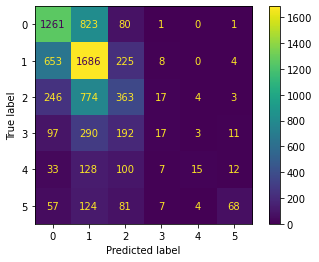

In [48]:
#plot confusion matrix
y_pred_log_cv = cross_val_predict(pipe_log, X_train2, y_train2, cv=5)

log_matrix = confusion_matrix(y_train2, y_pred_log_cv)
ConfusionMatrixDisplay(log_matrix).plot();

In [37]:
pipe_log = Pipeline([("vec", TfidfVectorizer()), ("log", LogisticRegression(max_iter=10000))])

In [39]:
#Grid search for hyperparameter tuning the Logistic Regression

#Define parameter grid for the vectorizer and Logistic regression
log_param_grid = {
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__min_df': [0.05, 0.1, 0.15, 0.2],
    'vec__max_df': [0.9, 0.95, 1.0],
    'log__penalty': [None, 'l2', 'l1'],
    'log__class_weight': [None, 'balanced'],
    'log__solver': ['lbfgs', 'liblinear'],
    'log__max_iter': [1000, 10000]
}


log_grid = GridSearchCV(pipe_log, log_param_grid, cv=5, verbose=2, scoring='accuracy')
log_grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  24.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  12.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  12.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  17.8s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.0s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_ran

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  14.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  12.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  14.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  14.6s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_ra

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  15.8s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  15.9s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_r

[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  15.7s
[CV] END log__class_weight=None, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_r

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 3.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.0min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  58.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  46.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  20.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  20.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  19.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1)

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 3.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_r

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 5.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_ra

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  28.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  26.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  29.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 4.6min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.6min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 4.0min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 3.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.0min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.0min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 6.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 5.9min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.4min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.1min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time= 1.5min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 4.7min
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  28.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  26.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  29.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1)

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  10.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  11.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  10.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  25.8s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  26.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  10.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2);

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   7.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec_

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngr

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.4s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2);

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.7s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.0s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, 

[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.9s
[CV] END log__class_weight=None, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  25.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  20.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  42.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  36.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  32.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  26.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  23.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  41.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  33.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  29.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  26.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=  24.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.2min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 1.1min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  21.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  22.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  38.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  40.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  39.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  20.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.2s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  18.8s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  19.3s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  37.4s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  36.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  34.6s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  35.5s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  16.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.7s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  13.9s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  31.7s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.0s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  30.1s


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  32.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9,

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__ma

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0,

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  19.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   7.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_ra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  18.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_ra

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  18.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, 

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.4s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_d

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.8s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_rang

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.6s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  12.9s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ng

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   4.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.1s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, 

[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.5s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  17.3s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  16.2s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   6.0s
[CV] END log__class_weight=balanced, log__max_iter=1000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.5min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.6min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.0min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  43.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  30.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  53.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.2min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.2,

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__m

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.2min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  45.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  31.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  52.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__mi

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  14.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  17.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  15.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=0.95, vec__min_d

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 4.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.1min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.6min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time= 2.9min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.9min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 1.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.8min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 1); total time= 2.7min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.1, vec__ngram_range=(1, 2); total time= 4.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  43.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  30.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  53.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  44.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.5min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 2.9min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.4min


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time= 3.3min
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  18.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  23.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  27.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=  22.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2,

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  21.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  19.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  19.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  20.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=None, log__solver=liblinear, vec__

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  34.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  31.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  31.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  29.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  11.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=  12.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.15, vec

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  25.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  25.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  24.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.2, vec__ng

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   8.6s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  22.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  22.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.9, vec__

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   6.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l2, log__solver=liblinear, vec__max_df=1.0, 

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.05, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   5.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.9, vec__min_df=0.1, vec__ngr

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  14.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__ngram_range=(1, 2); total time=  13.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=0.95, vec__min_df=0.1, vec__n

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   5.0s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 1); total time=   4.7s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  13.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=lbfgs, vec__max_df=1.0, vec__min_df=0.15, vec__n

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.15, vec__ngram_range=(1, 2); total time=  16.4s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.5s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.2s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec__min_df=0.2, vec__ngram_range=(1, 1); total time=   6.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.9, vec_

[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  17.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  16.3s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  16.1s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=0.95, vec__min_df=0.2, vec__ngram_range=(1, 2); total time=  18.9s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, vec__min_df=0.05, vec__ngram_range=(1, 1); total time=   7.8s
[CV] END log__class_weight=balanced, log__max_iter=10000, log__penalty=l1, log__solver=liblinear, vec__max_df=1.0, 

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
960 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 420, in

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log__class_weight': [None, 'balanced'],
                         'log__max_iter': [1000, 10000],
                         'log__penalty': [None, 'l2', 'l1'],
                         'log__solver': ['lbfgs', 'liblinear'],
                         'vec__max_df': [0.9, 0.95, 1.0],
                         'vec__min_df': [0.05, 0.1, 0.15, 0.2],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)

In [40]:
log_grid.best_params_

{'log__class_weight': None,
 'log__max_iter': 1000,
 'log__penalty': 'l2',
 'log__solver': 'lbfgs',
 'vec__max_df': 0.9,
 'vec__min_df': 0.05,
 'vec__ngram_range': (1, 2)}

In [41]:
log_grid.best_score_

0.45300878972278563

**The baseline Logistic Regression model performed better than the tuned Logistic Regression model above.**
   
   1. Untuned: accuracy = 46.11%
   2. Tuned: accuracy = 45.30%

### Decision Tree - ***New Regex Pattern***

In [25]:
pipe_dt = Pipeline([("vec", TfidfVectorizer()), ("dt", DecisionTreeClassifier(random_state=42))])

pipe_dt_score = np.mean(cross_val_score(pipe_dt, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_dt_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 32.52%


### Random Forest - ***New Regex Pattern***

Simple Random Forest Model without gridsearching hyperparameters

In [24]:
pipe_rf = Pipeline([("vec", TfidfVectorizer()), ("rf", RandomForestClassifier(random_state=42))])

pipe_rf_score = np.mean(cross_val_score(pipe_rf, X_train2, y_train2, cv=5, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy Score: {pipe_rf_score*100:,.2f}%")

Random Forest Cross Validation Accuracy Score: 39.12%


In [10]:
#Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Random Forest Model
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__min_samples_split': [2, 3, 4],
    'rf__max_depth': [None, 25, 50, 75, 100],
    'rf__class_weight': [None, 'balanced'],   
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__min_df': [0.01, 0.1, 0.2],
    'vec__max_df': [0.9, 0.95, 1.0]
}

forest_grid = GridSearchCV(pipe_rf, rf_param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-3)
forest_grid.fit(X_train2, y_train2)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5; 1/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)


/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5; 1/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   2.8s
[CV 2/5; 1/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 2/5; 1/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.5s
[CV 3/5; 1/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 3/5; 1/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.5s
[CV 4/5; 1/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 4/5

[CV 1/5; 6/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=  11.4s
[CV 2/5; 6/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 2/5; 6/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   1.9s
[CV 3/5; 6/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 3/5; 6/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   2.0s
[CV 4/5; 6/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 4/5

[CV 1/5; 11/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   6.6s
[CV 2/5; 11/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 2/5; 11/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   1.1s
[CV 3/5; 11/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 3/5; 11/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   1.1s
[CV 4/5; 11/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 4/5

[CV 1/5; 16/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   2.7s
[CV 2/5; 16/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 2/5; 16/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.5s
[CV 3/5; 16/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 3/5; 16/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 4/5; 16/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 4/5

[CV 1/5; 21/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=  13.5s
[CV 2/5; 21/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 2/5; 21/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.9s
[CV 3/5; 21/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 3/5; 21/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.9s
[CV 4/5; 21/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 3)
[

[CV 1/5; 26/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   8.0s
[CV 2/5; 26/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 2/5; 26/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   1.1s
[CV 3/5; 26/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 3/5; 26/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   1.1s
[CV 4/5; 26/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 2)
[

[CV 1/5; 31/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   2.8s
[CV 2/5; 31/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 2/5; 31/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.5s
[CV 3/5; 31/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 3/5; 31/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.5s
[CV 4/5; 31/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 1)
[

[CV 1/5; 36/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=  11.5s
[CV 2/5; 36/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 2/5; 36/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   1.9s
[CV 3/5; 36/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 3/5; 36/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   1.9s
[CV 4/5; 36/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 3)
[

[CV 1/5; 41/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   6.5s
[CV 2/5; 41/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 2/5; 41/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 3/5; 41/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 3/5; 41/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 41/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 4/5

[CV 1/5; 46/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   2.4s
[CV 2/5; 46/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 2/5; 46/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 3/5; 46/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 3/5; 46/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 4/5; 46/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 1)
[

[CV 1/5; 51/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   9.5s
[CV 2/5; 51/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 2/5; 51/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   1.5s
[CV 3/5; 51/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 3/5; 51/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time= 1.7min
[CV 4/5; 51/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 3)
[

[CV 1/5; 56/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   5.0s
[CV 2/5; 56/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 2/5; 56/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 3/5; 56/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 3/5; 56/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 56/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 2)
[

[CV 1/5; 61/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   2.0s
[CV 2/5; 61/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 2/5; 61/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 3/5; 61/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 3/5; 61/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 4/5; 61/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 1)
[

[CV 1/5; 66/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   9.4s
[CV 2/5; 66/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 2/5; 66/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.5s
[CV 3/5; 66/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 3/5; 66/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.6s
[CV 4/5; 66/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 4/5

[CV 1/5; 71/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   5.2s
[CV 2/5; 71/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 2/5; 71/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   0.9s
[CV 3/5; 71/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 3/5; 71/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   0.9s
[CV 4/5; 71/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 4/5

[CV 1/5; 76/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   2.1s
[CV 2/5; 76/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 2/5; 76/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 3/5; 76/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 3/5; 76/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 4/5; 76/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 1)
[

[CV 1/5; 81/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   9.5s
[CV 2/5; 81/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 2/5; 81/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   1.6s
[CV 3/5; 81/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 3/5; 81/729] END rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   2.0s
[CV 4/5; 81/729] START rf__class_weight=None, rf__min_samples_split=1, rf__n_estimators=90, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 3)
[

[CV 1/5; 86/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   5.3s
[CV 2/5; 86/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 2/5; 86/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.9s
[CV 3/5; 86/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 3/5; 86/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 86/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.88, vec__min_df=0.02, vec__ngram_range=(1, 2)
[

[CV 1/5; 91/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   1.9s
[CV 2/5; 91/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 2/5; 91/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 3/5; 91/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 3/5; 91/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 4/5; 91/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 4/5

[CV 1/5; 96/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   8.7s
[CV 2/5; 96/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 2/5; 96/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   1.4s
[CV 3/5; 96/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 3/5; 96/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3);, score=nan total time=   1.3s
[CV 4/5; 96/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 3)
[CV 4/5

[CV 1/5; 101/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   4.5s
[CV 2/5; 101/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 2/5; 101/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   0.9s
[CV 3/5; 101/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 2)
[CV 3/5; 101/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 101/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.01, vec__ngram_range=(1

[CV 1/5; 106/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   2.1s
[CV 2/5; 106/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 2/5; 106/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 3/5; 106/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 1)
[CV 3/5; 106/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 4/5; 106/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=86, vec__max_df=0.92, vec__min_df=0.03, vec__ngram_range=(1

[CV 1/5; 111/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   8.4s
[CV 2/5; 111/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 2/5; 111/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.4s
[CV 3/5; 111/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 3)
[CV 3/5; 111/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 3);, score=nan total time=   1.5s
[CV 4/5; 111/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1

[CV 1/5; 116/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   4.7s
[CV 2/5; 116/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 2/5; 116/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 3/5; 116/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 2)
[CV 3/5; 116/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 116/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.88, vec__min_df=0.03, vec__ngram_range=(1

[CV 1/5; 121/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   2.1s
[CV 2/5; 121/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 2/5; 121/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 3/5; 121/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1)
[CV 3/5; 121/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1);, score=nan total time=   0.4s
[CV 4/5; 121/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.02, vec__ngram_range=(1, 1)
[

[CV 1/5; 126/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   9.4s
[CV 2/5; 126/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 2/5; 126/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   1.4s
[CV 3/5; 126/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3)
[CV 3/5; 126/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3);, score=nan total time=   1.5s
[CV 4/5; 126/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.9, vec__min_df=0.03, vec__ngram_range=(1, 3)
[

[CV 1/5; 131/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   4.9s
[CV 2/5; 131/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 2/5; 131/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 3/5; 131/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 2)
[CV 3/5; 131/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1, 2);, score=nan total time=   0.8s
[CV 4/5; 131/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=88, vec__max_df=0.92, vec__min_df=0.02, vec__ngram_range=(1

[CV 1/5; 136/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   1.9s
[CV 2/5; 136/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 2/5; 136/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 3/5; 136/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1)
[CV 3/5; 136/729] END rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 4/5; 136/729] START rf__class_weight=None, rf__min_samples_split=2, rf__n_estimators=90, vec__max_df=0.88, vec__min_df=0.01, vec__ngram_range=(1

KeyboardInterrupt: 

In [ ]:
#plot confusion matrix
y_pred_rf_cv = cross_val_predict(rf_best, X_train_m, y_train_m, cv=5)

rf_conf_mat = confusion_matrix(y_train_m, y_pred_rf_cv)
ConfusionMatrixDisplay(rf_conf_mat).plot();

### KNN Model - ***New Regex Pattern***

Simple KNN model without GridSearch

In [31]:
# Construct a pipeline with the vectorizer and the KNN Classifier
pipe_knn = Pipeline([("vec", TfidfVectorizer()), ("knn", KNeighborsClassifier())])

# Run cross validation
pipe_knn_score = np.mean(cross_val_score(pipe_knn, X_train2, y_train2, scoring="accuracy", cv=5))

print(f"KNN Cross Validation Accuracy Score: {pipe_knn_score*100:,.2f}%")

KNN Cross Validation Accuracy Score: 38.76%


GridSearch the KNN pipeline:

In [ ]:
# Grid search for hyperparameter tuning the KNN Classifier

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [0.05, 0.1, 0.15, 0.2],
    'vectorizer__max_df': [0.9, 0.95, 1.0]
}

knn_grid = GridSearchCV(knn_pipe, knn_param_grid, scoring="accuracy", cv=5, n_jobs=-2, verbose=10)
knn_grid.fit(X_train_m, y_train_m)


### Naive Bayes Model

In [35]:
# Initialize the TF-IDF Vectorizer with specified min_df and max_df
tf = TfidfVectorizer()

# Transform the training and test data using the TF-IDF Vectorizer
X_train_tf = tf.fit_transform(X_train2.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test2.values)
X_test_tf = X_test_tf.toarray()

# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Perform cross-validation and calculate the mean accuracy
nb_score = np.mean(cross_val_score(nb_model, X_train_tf, y_train2, scoring="accuracy"))

print(f"Naive Bayes Cross Validation Accuracy: {nb_score*100:,.2f}%")

# Note: The Naive Bayes model and TF-IDF Vectorizer cannot be fitted into the same pipeline in this case.
# This requires separate steps for vectorization and model training.


Naive Bayes Cross Validation Accuracy: 29.76%
